### Few-shot learning 기반 얼굴 유사도 평가해보기

1. ORL face 데이터셋 살펴보기

In [1]:
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [14]:
print()
data_dir = f'{os.getcwd()}//computer_vision//1_Few_shot_learning//Face-Recognition'
phase = 'train'

os.path.join(data_dir, phase)

'C:\\Users\\Jamie\\j_notebook//computer_vision//1_Few_shot_learning//Face-Recognition\\train'

In [15]:
# 훈련 이미지 목록
def get_img (data_dir, phase) :
    person_items = []
    for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
        if len(files) > 0:
            for file_name in files:
                person_items.append(os.path.join(root, file_name))
    return person_items

In [16]:
person_items = get_img(data_dir, phase)
index = 0
faceA_path = person_items[index]
person = Path(faceA_path).parent.name #사람 폴더 명
same_person_dir = Path(faceA_path).parent # 같은사람 폴더주소
same_person_images = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')] # 같은 사람 폴더 내 이미지 명

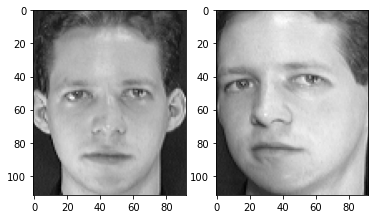

In [17]:
faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_images)) # 해당 폴더 내 이미지를 무작위로 선택

# 같은 사람의 이미지 선택
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

# 같은 사람의 이미지 2개 확인 가능
plt.figure()
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

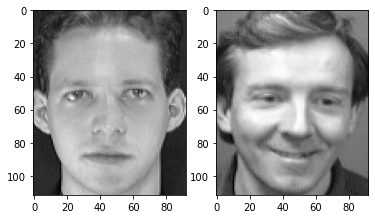

In [19]:
# 다른 사람의 이미지 찾기
import pandas as pd
diff_person_items = pd.Series(person_items)
diff_person_items = diff_person_items[(diff_person_items.str.contains(person))==False]
faceB_path = np.random.choice(diff_person_items)

faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

plt.figure()
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

2. Few-shot learning 을 위한 데이터셋 구축

In [70]:
a = os.walk(os.path.join(data_dir, phase))
for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
    print(root, dirs, files)

In [20]:
class Face_Dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.person_items = []
        for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name)) # 사진 경로 리스트

        self.transformer = transformer
        
    def __len__(self):
        return len(self.person_items)
    
    def __getitem__(self, index, ):
        faceA_path = self.person_items[index]
        person = Path(faceA_path).parent.name

        # positive나 negative 샘플이 랜덤하게 뽑힐 수 있도록 함(1 또는 0)
        same_person = np.random.randint(2)
        
        if same_person:
            same_person_dir = Path(faceA_path).parent
            same_person_fn = [fn for fn in os.listdir(same_person_dir) if fn.endswith("png")]
            faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_fn))

        else: # 다른 사람의 이미지를 가져오는 경우 탈출하도록 함
            diff_person_items = pd.Series(person_items)
            diff_person_items = diff_person_items[(diff_person_items.str.contains(person))==False]
            faceB_path = np.random.choice(diff_person_items)

        faceA_image = cv2.imread(faceA_path, 0)
        faceB_image = cv2.imread(faceB_path, 0)
        
        if self.transformer:
            faceA_image = self.transformer(faceA_image) # 이미지를 텐서로 변환시키는 역할
            faceB_image = self.transformer(faceB_image)
            
        return faceA_image, faceB_image, np.array([1-same_person]) # same person일 때 0, 다른 경우 1

In [23]:
data_dir = f'{os.getcwd()}//computer_vision//1_Few_shot_learning//Face-Recognition'
trn_ds = Face_Dataset(data_dir, phase="train")

(array([[48, 49, 45, ..., 56, 56, 54],
       [45, 52, 39, ..., 52, 50, 51],
       [45, 50, 42, ..., 48, 53, 50],
       ...,
       [50, 48, 50, ..., 45, 46, 46],
       [45, 54, 49, ..., 46, 47, 47],
       [51, 51, 51, ..., 47, 46, 46]], dtype=uint8), array([[101, 104, 104, ..., 109, 111, 108],
       [101, 101, 104, ..., 108, 109, 106],
       [102, 103,  99, ..., 108, 109, 109],
       ...,
       [ 68,  71,  72, ...,  47,  45,  45],
       [ 72,  78,  74, ...,  50,  45,  44],
       [ 71,  66,  72, ...,  42,  46,  43]], dtype=uint8), array([1]))
[1]


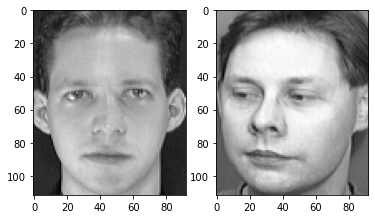

In [30]:
print(trn_ds[0]) # 객체에 인덱스로 접근 시 get_items으로 생성된 값 반환

faceA, faceB, other = trn_ds[0]
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(faceA, cmap='gray')
plt.subplot(122)
plt.imshow(faceB, cmap='gray')
print(other) # 1이면 다르고 0이면 같음

In [32]:
# 하나씩 비교
from ipywidgets import interact

@interact(index=(0, len(trn_ds)-1))
def show_sample(index=0):
    faceA, faceB, other = trn_ds[index]
    print(other)
    plt.figure(figsize=(6, 6))
    plt.subplot(121)
    plt.imshow(faceA, cmap='gray')
    plt.subplot(122)
    plt.imshow(faceB, cmap='gray')



interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

In [34]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [38]:
# 어그멘테이션 수행
# 어떤 어그멘테이션인지 확인 필요
def build_transformer(image_size=100):
    transformers = {}
    transformers["train"] = transforms.Compose([
        transforms.ToPILImage(), # PIL image로 변경
        transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=(0.9,1.1)), # 랜덤으로 affine 변형을 한다. 회전, 이동을 함
        transforms.RandomHorizontalFlip(), # 수평 뒤집기
        transforms.Resize((image_size,image_size)), # 100*100 사이즈
        transforms.ToTensor(), # 이미지 픽셀 값의 범위를 0~1로 조정
        transforms.Normalize((0.5), (0.5)) ])# 이미지 정규화 (평균/표준편차 0.5) -1~1로 조정

    # validation은 어그멘테이션이 필요 없음
    transformers["val"] = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size,image_size)), # image_size는 네트워크 입력 크기
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
    return transformers

In [40]:
IMAGE_SIZE = 100
transformers = build_transformer(image_size=IMAGE_SIZE)

tr_dataset = Face_Dataset(data_dir, phase="train", transformer=transformers["train"])
val_dataset = Face_Dataset(data_dir, phase="val", transformer=transformers["val"])

In [49]:
# 이미지 1, 이미지 2, 일치 여부(0, 1)
print(len(tr_dataset[0]))
# 그레이스케일1, 이미지 사이즈 100, 100
tr_dataset[0][0].shape

3


torch.Size([1, 100, 100])

In [50]:
# 샘플들을 미니배치(minibatch)로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막음
tr_dataloader = DataLoader(tr_dataset, shuffle=True, batch_size = 64)


In [53]:
# 데이터셋 빌딩
def build_dataloader(data_dir, batch_size=64):
    dataloaders = {}
    
    transformers = build_transformer()
    tr_dataset = Face_Dataset(data_dir, phase="train", transformer=transformers["train"])
    dataloaders["train"] = DataLoader(tr_dataset, shuffle=True, batch_size=batch_size)
    
    val_dataset = Face_Dataset(data_dir, phase="val", transformer=transformers["val"])
    dataloaders["val"] = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
    return dataloaders

In [54]:
data_dir = f'{os.getcwd()}//computer_vision//1_Few_shot_learning//Face-Recognition'
BATCH_SIZE = 64
dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)

In [55]:
for _ in range(3):
    for phase in ["train", "val"]:
        for index, batch in enumerate(dataloaders[phase]):
            faceAs = batch[0]
            faceBs = batch[1]
            others = batch[2]
            if index % 100 == 0:
                print(f"{phase} - {index}/{len(dataloaders[phase])}")

train - 0/2
val - 0/1
train - 0/2
val - 0/1
train - 0/2
val - 0/1


## 3. Siamese network 아키텍처 소개와 구현해보기

In [60]:
import torch
from torch import nn

In [116]:
def convBlock(in_channel, out_channel, k, mp=True):
    if mp :
        model = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=k), # padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
            #nn.BatchNorm2d(out_channel)
        )
    else :
        model = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=k), # padding=1),
            nn.ReLU(inplace=True)
        )
    return model

In [125]:
# 샴네트워크 구조 생성
conv1 = convBlock(1,64, 10)
x3 = conv1(x1)
print(x3.shape)

conv2 = convBlock(64, 128, 7)
x4 = conv2(x3)
print(x4.shape)

conv3 = convBlock(128, 128, 4)
x5 = conv3(x4)
print(x5.shape)

conv4 = convBlock(128, 256, 4, 0)
x6 = conv4(x5)
print(x6.shape)

nn.Flatten(x6),
class SiameseNetwork(nn.Module):
    def __init__(self, input_channel):
        super().__init__()
        self.features = nn.Sequential(
            convBlock(1,64, 10),
            convBlock(64, 128, 7),
            convBlock(128, 128, 4),
            convBlock(128, 256, 4, 0),
            nn.Flatten(),
            nn.Linear(256*6*6, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x1, x2):
        out1 = self.features(x1)
        out2 = self.features(x2)
        return out1, out2

torch.Size([1, 64, 48, 48])
torch.Size([1, 128, 21, 21])
torch.Size([1, 128, 9, 9])
torch.Size([1, 256, 6, 6])


In [126]:
IMAGE_SIZE = 105
x1 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE) # 정규분포를 가지는 더미 이미지 생성
x2 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)
model = SiameseNetwork(input_channel=1)

out1, out2 = model(x1, x2)

In [127]:
out1.shape

torch.Size([1, 10])

In [ ]:
# 모델 테스트
IMAGE_SIZE = 100
x1 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE) # 정규분포를 가지는 더미 이미지 생성
x2 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)

model = SiameseNetwork(input_channel=1)

out1, out2 = model(x1, x2)

In [128]:
print(x1)

tensor([[[[-2.0293,  2.5409, -0.2466,  ..., -0.5393,  0.8602,  0.6460],
          [-0.5377,  0.8701, -1.1211,  ..., -0.6521, -0.0205,  1.5015],
          [-1.4556, -1.0656, -0.4249,  ..., -1.4325,  2.0882,  0.6535],
          ...,
          [-0.2825,  1.7316, -0.1442,  ..., -0.9130,  0.6100, -0.4630],
          [ 1.2883, -0.0830, -0.4833,  ...,  0.5176,  0.1881,  1.0867],
          [-1.2016, -0.0947, -0.6223,  ...,  2.2682, -0.8309,  0.4831]]]])


In [129]:
print(out1.shape)
print(out2.shape)

torch.Size([1, 10])
torch.Size([1, 10])


## 4. Contrastive loss function 설명 및 구현해보기

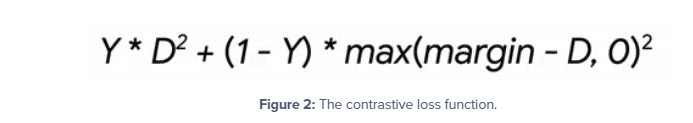
출처: https://pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
loss function 은 minimize가 목적

Y는 positive 샘플일 경우 1, negative일 경우 0
D 두가지 latent vector에 대한 distance

같은 경우 1이면 앞의 식만 인정 - 거리가 줄어드는 방향으로 학습
다른 경우 0이면 뒤의 식만 인정 max(margin - D, 0)

margin : 네트워크가 어떤 임계점을 기준으로 학습할 것인지
margin이 2라면 D의 최대치가 2가 되도록 학습
max 값의 제곱이 최소화되도록 학습습거리값은 margin -D가 최소화하는 방향으로 네트워크를 학습 시킴
D를 증가시키는 방향으로 학습을 시킨다는 것

In [130]:
import torch.nn.functional as F

In [131]:
# same 일때는 0, other일 경우 1
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
    def forward(self, z1, z2, label):
        dist = F.pairwise_distance(z1, z2, keepdim = True)

In [98]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True) #기본 L2-norm, 벡터의 차원 유지 keepdim= True
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.clamp(self.margin**2 - torch.pow(euclidean_distance, 2), min=0.0))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

## 5. Face recognition을 위한 학습코드 작성해보기

In [99]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    losses = {}
    accuracies = {}
    
    for phase in ["train", "val"]:
        running_loss = 0.0
        running_acc = 0
        
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        for index, batch in enumerate(dataloaders[phase]):
            imgA = batch[0].to(device)
            imgB = batch[1].to(device)
            label = batch[2].to(device)
            
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                codeA, codeB = model(imgA, imgB)
            loss, acc = criterion(codeA, codeB, label)
                
            if phase == "train":
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
            running_acc += acc.item()
                    
        losses[phase] = running_loss/len(dataloaders[phase])
        accuracies[phase] = running_acc/len(dataloaders[phase])
    return losses, accuracies

In [117]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    losses = {}
    accuracies = {}

    for phase in ["train", "val"]:
        running_loss = 0.0
        running_acc = 0.0

        if phase == "train" :
            model.train()
        else :
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):
            imgA = batch[0].to(device)
            imgB = batch[1].to(device)
            label = batch[2].to(device)

            with torch.set_grad_enabled(phase == 'train'):
                codeA, codeB = model(imgA, imgB)

            loss, acc = criterion(codeA, codeB, label)

            if phase == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            running_acc +=acc.item()

        losses[phase] = running_loss/len(dataloaders[phase])
        accuracies[phase] = running_acc/len(dataloaders[phase])

    return losses, accuracies

In [118]:
def save_model(model_state, model_name, save_dir=f"{path}/trained_model"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [119]:
data_dir = f"{path}/DATASET/Face-Recognition"
is_cuda = True

IMAGE_SIZE = 100
BATCH_SIZE = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = SiameseNetwork(input_channel=1)
model = model.to(DEVICE)
criterion = ContrastiveLoss(margin=2.0)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [120]:
dataloaders['val']


In [121]:
num_epochs = 100 #  학습 epoch

best_epoch = 0
best_score = 0.0
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    losses, accs = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_acc.append(accs["train"])
    val_acc.append(accs["val"])
    
    print(f"{epoch}/{num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['val']:.4f}")
    print(f"{epoch}/{num_epochs} - Train acc: {accs['train']:.4f}, Val acc: {accs['val']:.4f}")
        
    if (epoch+1) % 20 == 0:
        save_model(model.state_dict(), f'model_{epoch+1}.pth')

0/100 - Train loss: 2.2748, Val loss: 2.1333
0/100 - Train acc: 0.4286, Val acc: 0.4667
1/100 - Train loss: 2.0036, Val loss: 2.1332
1/100 - Train acc: 0.5000, Val acc: 0.4667
2/100 - Train loss: 2.2637, Val loss: 1.0666
2/100 - Train acc: 0.4286, Val acc: 0.7333
3/100 - Train loss: 2.0426, Val loss: 1.7332
3/100 - Train acc: 0.4857, Val acc: 0.5667
4/100 - Train loss: 2.2800, Val loss: 1.8665
4/100 - Train acc: 0.4286, Val acc: 0.5333
5/100 - Train loss: 2.5762, Val loss: 2.1330
5/100 - Train acc: 0.3429, Val acc: 0.4667
6/100 - Train loss: 2.2846, Val loss: 1.9996
6/100 - Train acc: 0.4571, Val acc: 0.5000
7/100 - Train loss: 1.5194, Val loss: 1.8657
7/100 - Train acc: 0.6857, Val acc: 0.5333
8/100 - Train loss: 1.6042, Val loss: 1.9983
8/100 - Train acc: 0.6429, Val acc: 0.5000
9/100 - Train loss: 1.7862, Val loss: 2.6627
9/100 - Train acc: 0.7000, Val acc: 0.3333
10/100 - Train loss: 1.5253, Val loss: 1.4626
10/100 - Train acc: 0.8000, Val acc: 0.6333
11/100 - Train loss: 1.5040, V

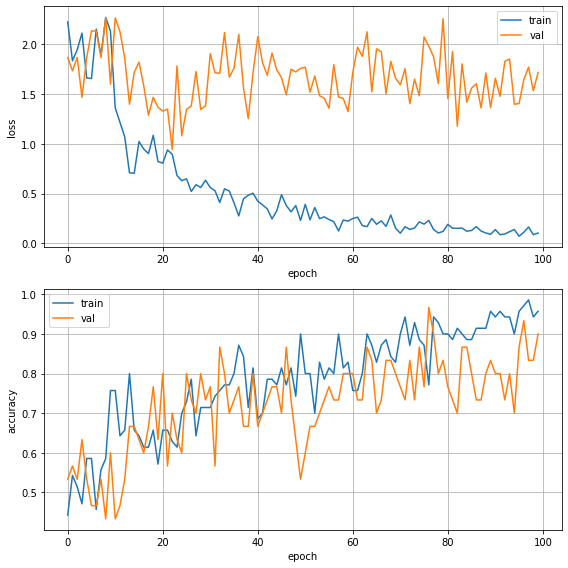

## 6. 학습한 모델로 유사도 평가해보기

In [131]:
def load_model(ckpt_path, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = SiameseNetwork()
    model.load_state_dict(checkpoint)
    model.eval()
    return model.to(device)

In [132]:
ckpt_path = "./trained_model/model_100.pth"
is_cuda = False

IMAGE_SIZE = 100
DEVICE = torch.device('cuda' if is_cuda and torch.cuda.is_available() else 'cpu')
model = load_model(ckpt_path, DEVICE)

FileNotFoundError: [Errno 2] No such file or directory: './trained_model/model_100.pth'

In [133]:
transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [134]:
from ipywidgets import interact

In [135]:
@torch.no_grad()
def recognize_face(dataset, index, model, device):
    val_dataset = dataset(data_dir, phase="val")
    faceA, faceB, label = val_dataset[index]
    tensor_faceA = transformer(faceA).to(device) #(C, H, W) # (1, 100, 100)
    tensor_faceB = transformer(faceB).to(device) #(C, H, W) normalize 된 텐서 형태로 변경
    
    codeA, codeB = model(tensor_faceA.unsqueeze(0), tensor_faceB.unsqueeze(0)) #(B, C, H, W) / (1, 1, 100, 100)
    euclidean_distance = F.pairwise_distance(codeA, codeB)
    
    output = "Same person" if euclidean_distance.item() < 0.6 else "Different person"
    return faceA, faceB, euclidean_distance.item(), output

In [136]:
@interact(index=(0,29), continuous_update=False)
def show_result(index=0):
    faceA, faceB, distance, output = recognize_face(Face_Dataset, index, model, DEVICE)
    plt.figure(figsize=(7, 4))
    plt.suptitle(f"{output} - Dissimilarity: {distance:.2f}")
    plt.subplot(121)
    plt.imshow(faceA, cmap='gray')
    plt.subplot(122)
    plt.imshow(faceB, cmap='gray')
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=29), Output()), _dom_classes=('widget-intera…

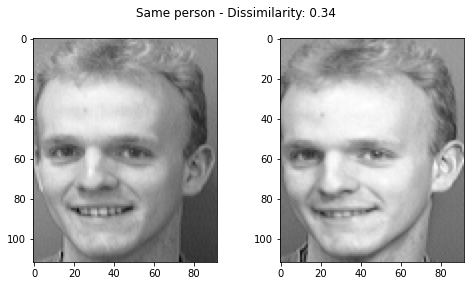

In [137]:
faceA, faceB, distance, output = recognize_face(Face_Dataset, index, model, DEVICE)
plt.figure(figsize=(7, 4))
plt.suptitle(f"{output} - Dissimilarity: {distance:.2f}")
plt.subplot(121)
plt.imshow(faceA, cmap='gray')
plt.subplot(122)
plt.imshow(faceB, cmap='gray')
plt.tight_layout()